In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [2]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        inlist = 0
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [3]:
hyp_res = parse_results('grid_search_results/hyp_overall-liking_100.txt')
euc_res = parse_results('grid_search_results/euc_overall-liking_100.txt')

In [4]:
hyp_param_grid = {
    'model_type': ['hyp'],
    'num_hidden_layers': [0,1,2,4,8,16],
    'layer_size': [2,4,8,16,32,64,128,192,256,448,512],
    'lr': [0.003,0.004,0.005],
    'weight_decay': [0.001],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

euc_param_grid = {
    'model_type': ['euc'],
    'num_hidden_layers': [0,1,2,4,8,16],
    'layer_size': [2,4,8,16,32,64,128,192,256,448,512],
    'lr': [0.0025,0.003,0.0035],
    'weight_decay': [0.0005],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

In [5]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape

(198, 3, 100)

In [6]:
IN_SIZE = 89
OUT_SIZE = 1

NUM_HIDDEN_LAYERS = [0,1,2,4,8,16]
LAYER_SIZE = [2,4,8,16,32,64,128,192,256,448,512]
LR = [0.003, 0.004, 0.005]

In [7]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

naive_sizes = (num_hidden_layers * layer_size**2).flatten()
real_sizes = (num_hidden_layers * layer_size**2).flatten() + ((np.zeros_like(num_hidden_layers) + (IN_SIZE+OUT_SIZE))*layer_size).flatten()

In [8]:
tri.triangles

NameError: name 'tri' is not defined

In [9]:
print(num_hidden_layers[:12])
print(num_hidden_layers)

[0 0 0 0 0 0 0 0 0 0 0 1]
[ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2  2
  2  2  2  2  2  2  2  2  2  4  4  4  4  4  4  4  4  4  4  4  8  8  8  8
  8  8  8  8  8  8  8 16 16 16 16 16 16 16 16 16 16 16]


-2.8482200705010357 -3.039611424320429
-1.408446685865852 -1.3626851242213305


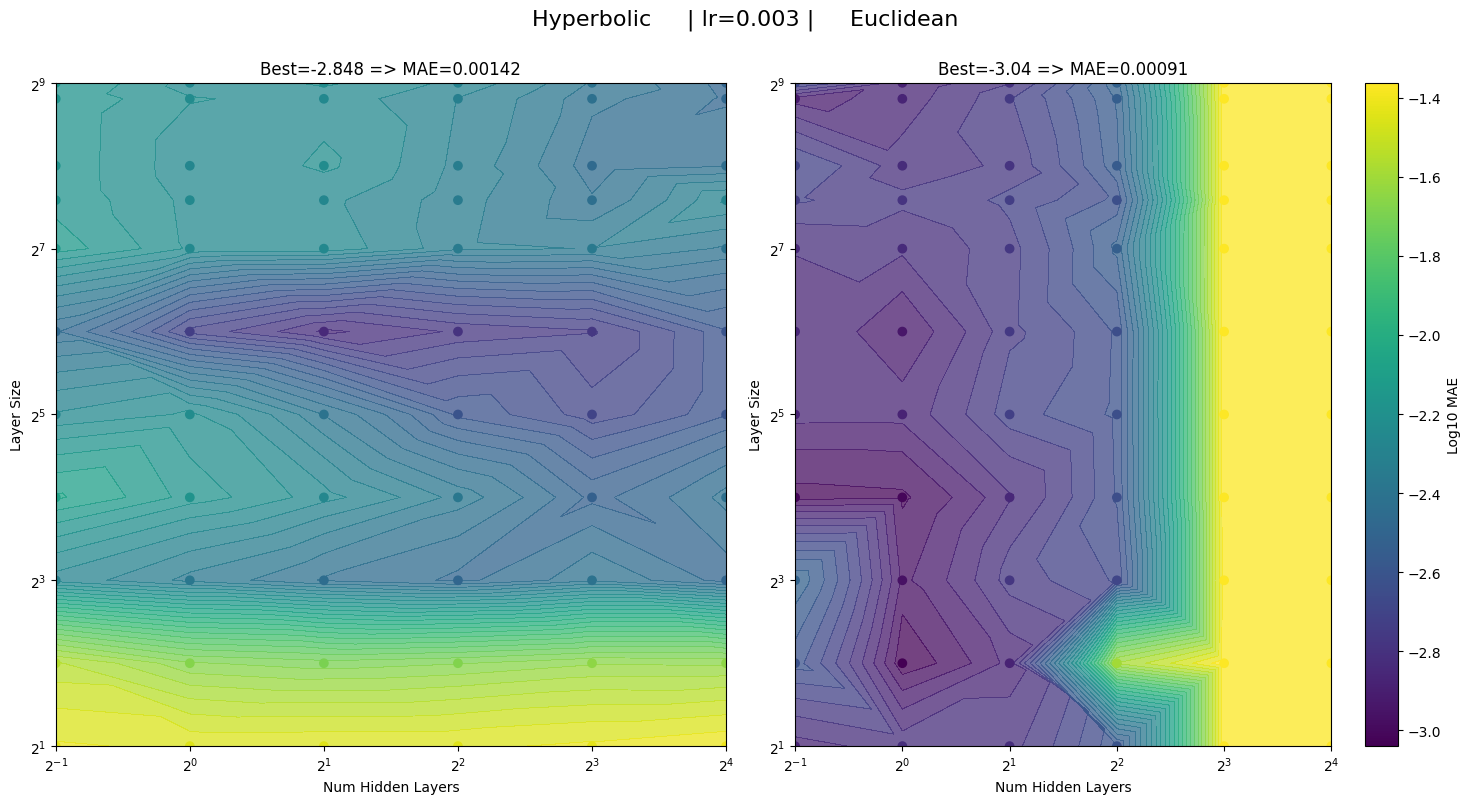

-2.911620715406935 -3.0513818459536215
-1.4040707981950198 -1.3633498836683124


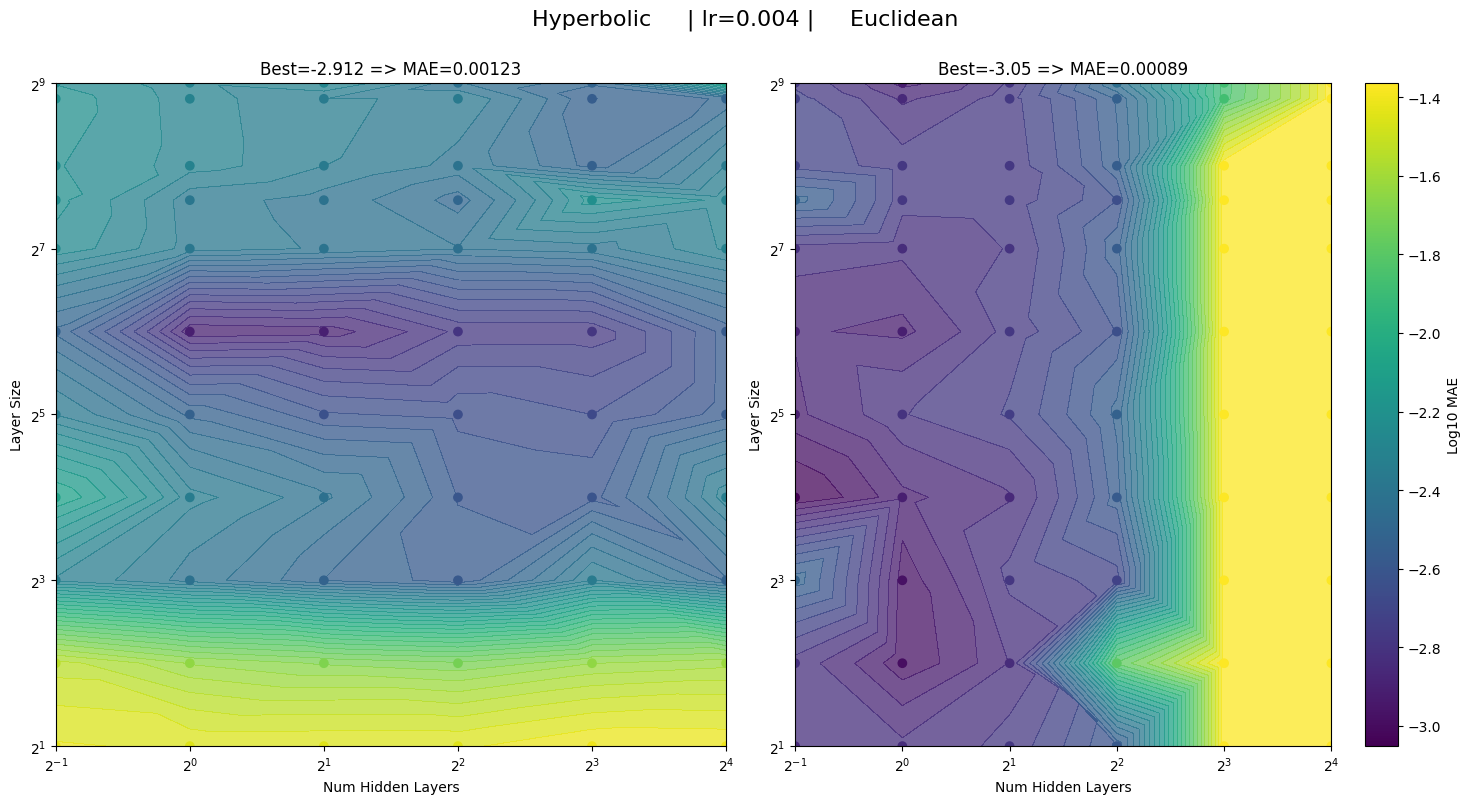

-2.9526619158851735 -2.999828733554232
-1.363913782725731 -1.3632626983362564


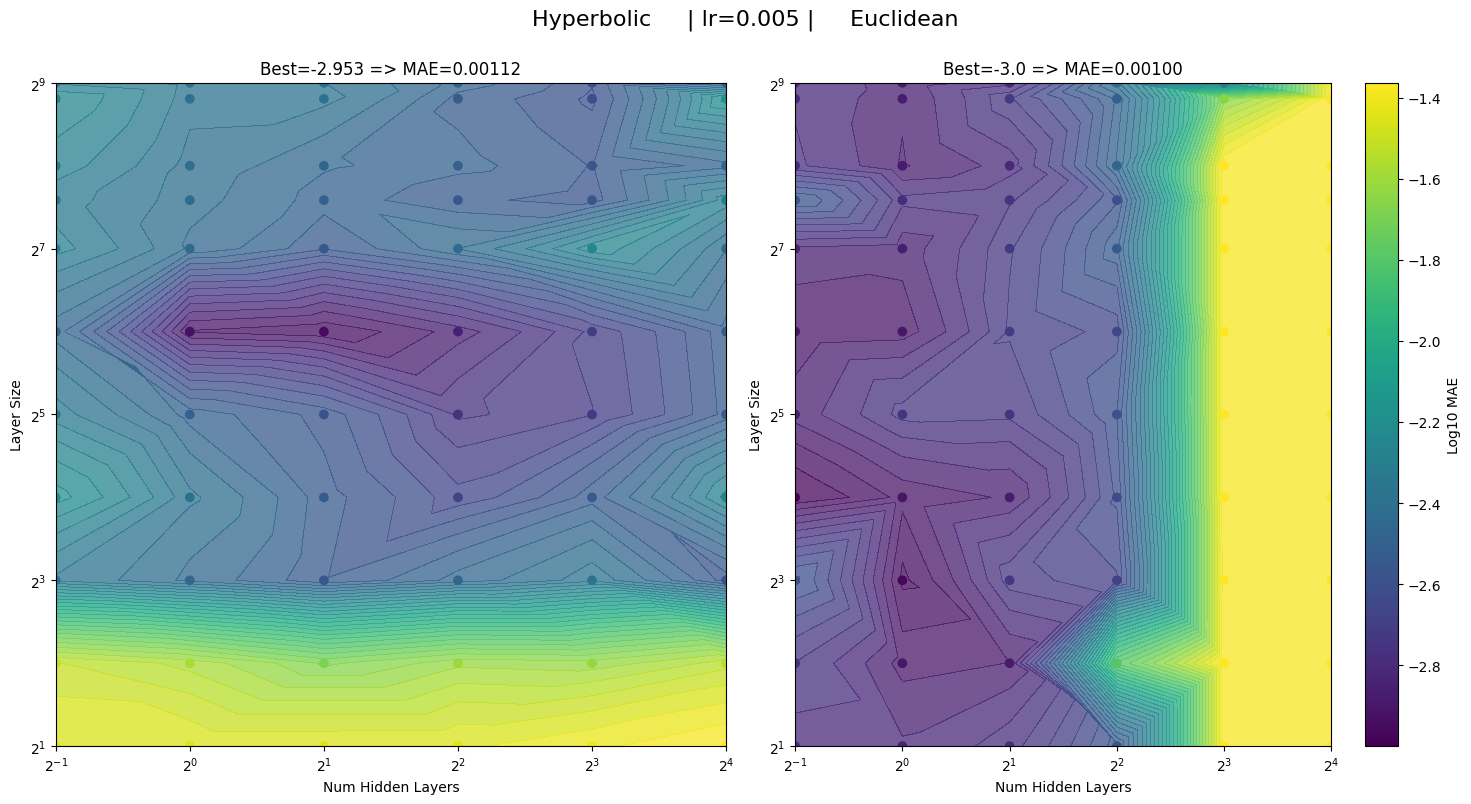

In [15]:
for i, lr in enumerate(LR):
    hyp_data = np.log10(hyp_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])
    euc_data = np.log10(euc_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i])

    min_val = min(np.min(hyp_data), np.min(euc_data))
    max_val = max(np.max(hyp_data), np.max(euc_data))

    print(np.min(hyp_data), np.min(euc_data))
    print(np.max(hyp_data), np.max(euc_data))

    cmap = plt.cm.viridis
    norm = Normalize(vmin=min_val, vmax=max_val)

    num_hidden_layers_adjust = np.append(np.zeros(11)+0.5, num_hidden_layers[11:])

    mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


    plt.figure(figsize=(15,8))
    plt.suptitle(f'Hyperbolic     | lr={lr} |     Euclidean', fontsize=16, y=1)

    plt.subplot(121)
    ctf = plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

    plt.title(f'Best={np.min(hyp_data):.3f} => MAE={np.power(10, np.min(hyp_data)):.5f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)


    plt.subplot(122)
    ctf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
    plt.colorbar(euc_scatter, label='Log10 MAE')


    plt.title(f'Best={np.min(euc_data):.3} => MAE={np.power(10, np.min(euc_data)):.5f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

    plt.tight_layout()
    plt.show()

In [ ]:
#